# Predict Restaurant Ratings

### Objective: 
- Build a machine learning model to predict theaggregate rating of a restaurant based on other features.

### Steps:

- Preprocess the dataset by handling missing values,encoding categorical variables, and splitting the datainto training and testing sets.
- Select a regression algorithm (e.g., linear regression,decision tree regression) and train it on the training data.
- Evaluate the model's performance using appropriateregression metrics (e.g., mean squared error, R-squared)on the testing data.
- Interpret the model's results and analyze the mostinfluential features affecting restaurant ratings.

In [268]:
#pip install wordcloud

In [332]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

from wordcloud import WordCloud
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

In [270]:
df = pd.read_csv('dataset.csv')

In [272]:
col_mask = {
    'Restaurant ID' : 'restaurant_id', 'Restaurant Name' : 'restaurant_name', 
    'Country Code' : 'country_code', 'City' : 'city', 'Address' : 'address',
       'Locality' : 'locality', 'Locality Verbose' : 'locality_verbose', 
       'Longitude' : 'longitude', 'Latitude' : 'latitude', 'Cuisines' : 'cuisines',
       'Average Cost for two' : 'average_cost_for_two', 'Currency' : 'currency', 
       'Has Table booking' : 'has_table_booking','Has Online delivery' : 'has_online_delivery', 
       'Is delivering now' : 'is_delivering_now', 'Switch to order menu' : 'switch_to_order_menu',
       'Price range' : 'price_range', 'Aggregate rating' : 'aggregrate_rating', 
       'Rating color' : 'rating_color', 'Rating text' : 'rating_text', 'Votes' : 'votes'
}

df = df.rename(columns = col_mask)

## 1. EDA Questions

1. What are the most common cuisines offered by restaurants in the dataset?

2. Which cuisines have the highest average aggregate ratings, and which have the lowest?

3. Do restaurants that offer table booking services have higher average ratings than those that don’t?

4. Is there a relationship between the number of votes a restaurant receives and its average rating?

5. How do restaurant ratings vary across different price ranges?

6. Which cities or localities have the highest concentration of restaurants?

7. What is the distribution of rating texts (e.g. Excellent, Good, Poor), and how do they correlate with rating colors and rating values?

8. How many restaurants offer online delivery, and how is their average rating compared to those that don’t?

9. Which currencies are most frequently used by restaurants in the dataset, and what countries do they correspond to?

10. Are certain cities or countries more likely to have restaurants that support online delivery or table bookings?

#### 1. What are the most common cuisines offered by restaurants in the dataset?

In [273]:
df['cuisines'] = df['cuisines'].fillna('')

In [274]:
df['cuisine_list'] = df['cuisines'].apply(lambda x: [c.strip() for c in x.split(',')])

In [275]:
flat = [item for sublist in df['cuisine_list'] for item in sublist] #flatten to one list

flat_dict = {}

for i in flat:
    if i in flat_dict:
        flat_dict[i] += 1
    else:
        flat_dict[i] = 1

In [276]:
dict(sorted(flat_dict.items(), key=lambda x: x[1], reverse=True)) #sort dictionary

{'North Indian': 3960,
 'Chinese': 2735,
 'Fast Food': 1986,
 'Mughlai': 995,
 'Italian': 764,
 'Bakery': 745,
 'Continental': 736,
 'Cafe': 703,
 'Desserts': 653,
 'South Indian': 636,
 'Street Food': 562,
 'American': 390,
 'Pizza': 381,
 'Mithai': 380,
 'Burger': 251,
 'Thai': 234,
 'Asian': 233,
 'Beverages': 229,
 'Ice Cream': 226,
 'Mexican': 181,
 'Biryani': 177,
 'Seafood': 174,
 'Healthy Food': 150,
 'European': 148,
 'Japanese': 135,
 'Finger Food': 114,
 'Raw Meats': 114,
 'Mediterranean': 112,
 'Salad': 93,
 'Sushi': 75,
 'Indian': 70,
 'Lebanese': 69,
 'Steak': 62,
 'Sandwich': 53,
 'Tea': 48,
 'Tibetan': 44,
 'Breakfast': 41,
 'Bar Food': 39,
 'BBQ': 33,
 'French': 29,
 'Juices': 29,
 'Bengali': 29,
 'Brazilian': 28,
 'Arabian': 28,
 'Hyderabadi': 26,
 'Southern': 24,
 'Vegetarian': 23,
 'Kerala': 23,
 'Middle Eastern': 22,
 'Malaysian': 22,
 'Korean': 21,
 'Grill': 21,
 'International': 21,
 'Vietnamese': 21,
 'Rajasthani': 21,
 'Goan': 20,
 'Kashmiri': 20,
 'Coffee and 

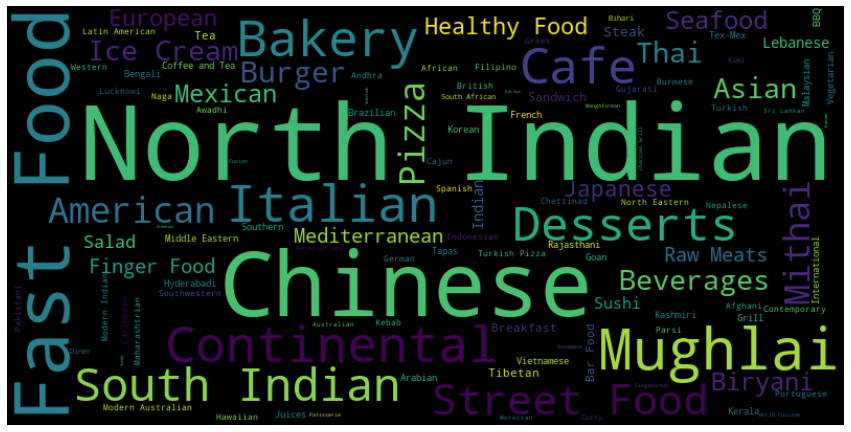

In [277]:
frequencies = flat_dict

wordcloud = WordCloud(background_color='black', width=800, height=400).generate_from_frequencies(frequencies)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

#### 2 Do restaurants that offer table booking services have higher average ratings than those that don’t?

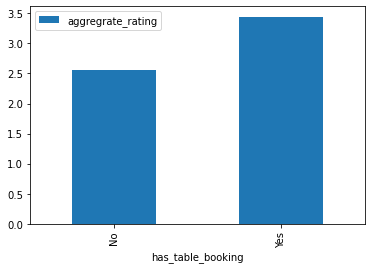

In [278]:
means = df.pivot_table('aggregrate_rating', 'has_table_booking', aggfunc="mean")

means.plot.bar();

#### 3. Is there a relationship between the number of votes a restaurant receives and its average rating?


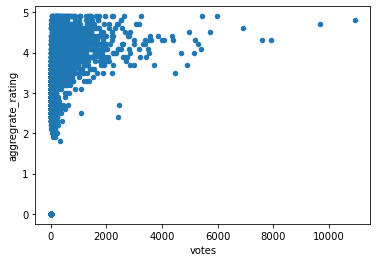

In [279]:
df.plot.scatter('votes','aggregrate_rating');

**1. Most restaurants have fewer than 4000 votes**

The data points are heavily concentrated in the left portion of the graph, suggesting that the majority of restaurants receive between 0 to 4000 votes. Very few exceed this range.

**2. No strong correlation between number of votes and ratings**

While there are restaurants with both high votes and high ratings, there are also many with low votes but still high ratings. This indicates that a restaurant doesn't necessarily need thousands of votes to achieve a high rating.


**3. Outliers exist on both axes**

A few restaurants have very high vote counts (over 10,000) but not necessarily the highest ratings.

There are also some with very low ratings, including one or two with a rating close to 0 — likely due to poor reviews or system defaults.

**4. Ratings cluster near the top**

Most ratings seem to be between 3.0 and 5.0, which suggests customers are generally more inclined to leave positive feedback, or lower-rated places don’t get rated often.

#### 4. Which cities or localities have the highest concentration of restaurants?

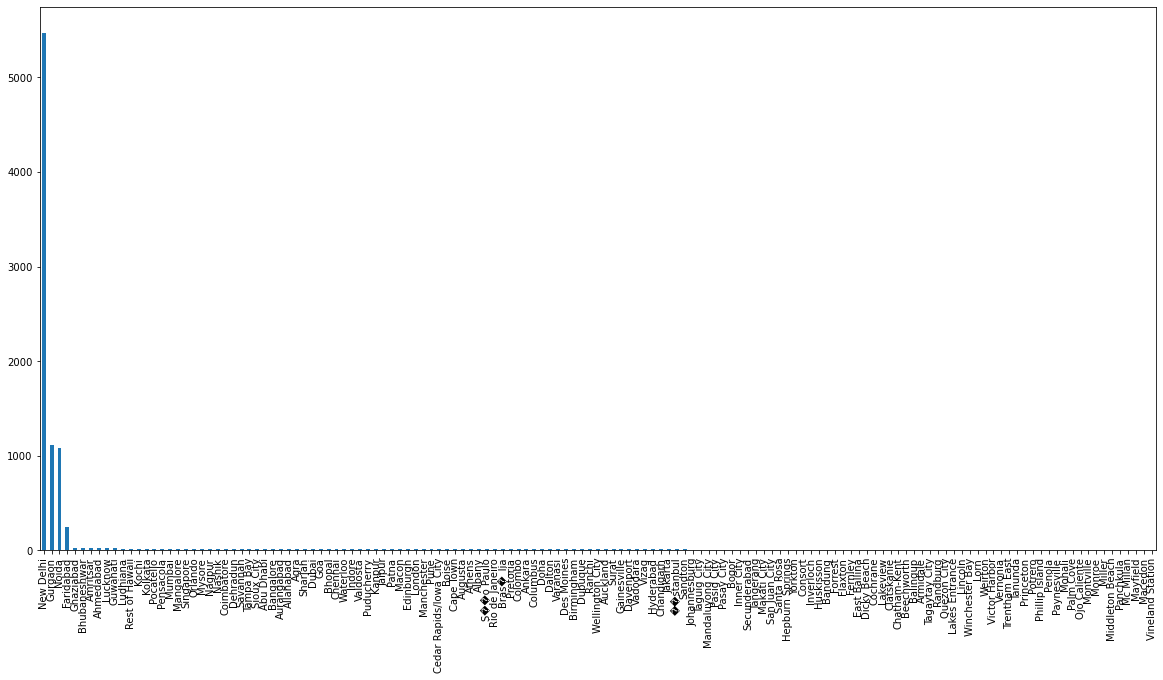

In [280]:
df['city'].value_counts(ascending=False).plot.bar(figsize=(20,10));

#### 5 Which currencies are most frequently used by restaurants in the dataset, and what countries do they correspond to?

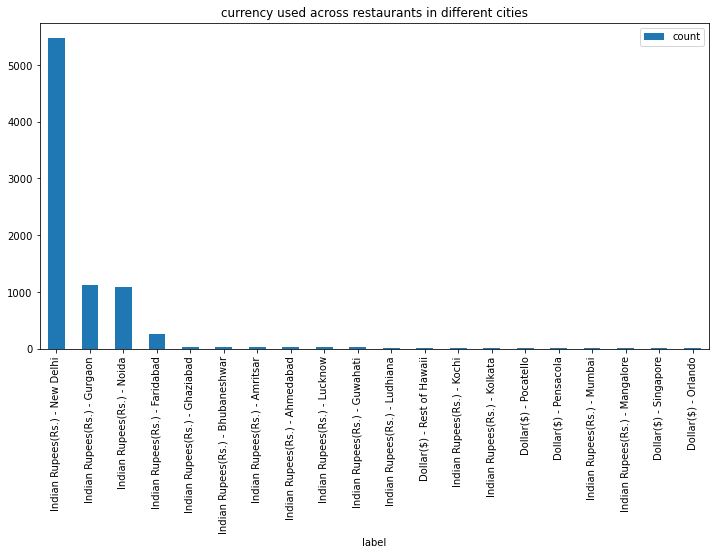

In [281]:
# Group and count number of restaurants per currency-country pair
df_grouped = df.groupby(['currency', 'city']).size().reset_index(name='count')

# Sort by count
df_grouped = df_grouped.sort_values(by='count', ascending=False)

# Combine currency and country into one label for clarity
df_grouped['label'] = df_grouped['currency'] + ' - ' + df_grouped['city']

#pick top 20 to avoid cluster
top_20 = df_grouped.nlargest(20,columns='count')

# Plot
top_20.plot(kind='bar', x = 'label', y = 'count', title = 'currency used across restaurants in different cities',figsize=(12,6));


## 2. Feature Engineering

In [286]:
df_copy = df.copy()
df_copy = df_copy[['restaurant_id', 'longitude', 'latitude','average_cost_for_two', 
              'has_table_booking','has_online_delivery', 'is_delivering_now', 
              'price_range', 'aggregrate_rating', 'rating_text','votes']]

In [287]:
map = {'Yes': 1, 'No' : 0}

df_copy['has_table_booking'] = df_copy['has_table_booking'].replace(map)
df_copy['has_online_delivery'] = df_copy['has_online_delivery'].replace(map)
df_copy['is_delivering_now'] = df_copy['is_delivering_now'].replace(map)

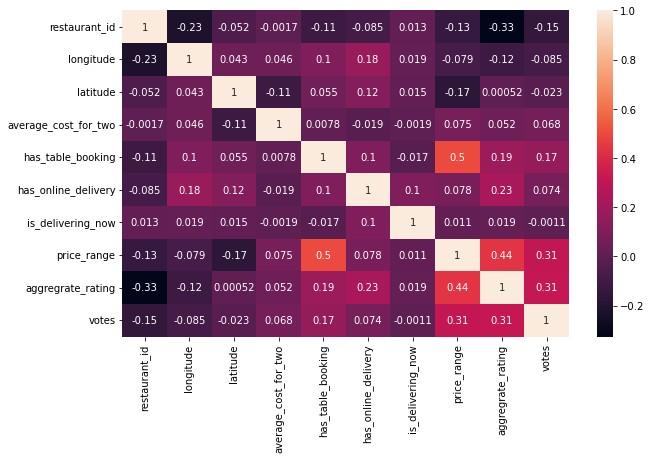

In [294]:
plt.figure(figsize=(10,6))
sb.heatmap(df_copy.corr(numeric_only=True),annot=True);

In [ ]:
# Create encoder with unknown handling
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform
result = encoder.fit_transform(df[['order_status']])

# Convert to DataFrame with readable column names
encoded_df = pd.DataFrame(result, columns=encoder.get_feature_names_out(['order_status']), index=cleaned_df.index) #index = df.index to preserve the index position

# Optional: Join with original DataFrame
final_df = pd.concat([cleaned_df, encoded_df], axis=1)

0    9517
1      34
Name: is_delivering_now, dtype: int64

In [306]:
encoder =   OneHotEncoder(handle_unknown='ignore', sparse_output = False)

result = encoder.fit_transform(df_copy[['rating_text']])

encoded_df = pd.DataFrame(result,columns = encoder.get_feature_names_out(['rating_text']), index = df_copy.index)

df_copy = pd.concat([df_copy,encoded_df],axis=1)

## 3. Modelling

In [312]:
X = df_copy.drop(['rating_text','aggregrate_rating'],axis=1)
y = df['aggregrate_rating']

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [315]:
#linear regression model

lr = LinearRegression()
lr.fit(X_train,y_train)

lr_model = lr.predict(X_test)

In [333]:
##KNN

knn = KNeighborsRegressor()
knn.fit(X_train,y_train)

knn_model = knn.predict(X_test)

In [335]:
##decision tree

dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)

dt_model = dt.predict(X_test)

In [336]:
##random forest

rf = RandomForestRegressor()
rf.fit(X_train,y_train)

rf_model = rf.predict(X_test)

In [338]:
print('RMSE for linear reg model:',np.sqrt(mean_squared_error(y_test,lr_model)))
print('RMSE for KNN model:',np.sqrt(mean_squared_error(y_test,knn_model)))
print('RMSE for decision Reg model:',np.sqrt(mean_squared_error(y_test,dt_model)))
print('RMSE for random forest model:',np.sqrt(mean_squared_error(y_test,rf_model)))

RMSE for linear reg model: 0.17614905182615162
RMSE for KNN model: 1.1706228802592658
RMSE for decision Reg model: 0.2269286201417877
RMSE for random forest model: 0.16786744571295997


Base on the rule of thumb, the KNN model performed badly, and random forest model perfomed the best

### 🧠 A good rule of thumb to check if your RMSE is small enough

In [328]:
# RMSE / (Max value of target - Min value of target) < 0.1

This checks:
“Is my model’s average prediction error less than 10% of the full range of the target?”

#### ✅ Why it matters:

Because RMSE is not normalized — it depends on the scale of your target.

So an RMSE of 10:

- is terrible if you're predicting something like house prices in thousands (e.g., $1000)

-  but awesome if you're predicting test scores out of 1000

That’s why comparing RMSE to the range of your target gives you perspective.

#### 🔍 Example:

Let’s say you're predicting restaurant ratings (y) that go from 1.0 to 5.0.

1. Range of target = 5.0 - 1.0 = 4.0

2. Your RMSE = 0.176

3. Calculate:

In [ ]:
# 0.176 / 4.0 = 0.044 = 4.4%

✅ That’s less than 10%, so your model error is low relative to the range. That's considered good.

### 🚨 When it’s not good:

If your RMSE is large relative to the target range:

- Say RMSE = 2.5, and your target range is 4.0

- Then `2.5 / 4 = 0.625`~ → ❌ 62.5% → too high → your model predictions are off by a large margin.

### Model Imporvement